## Example of analysis

In this notebook, we show how to read the parameters of the RBM and show some observables. The saved models can be found at : 

In [1]:
import sys
sys.path.append('src/')
import torch
import rbm
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import h5py 

device = torch.device("cpu")
# Uncomment if you have a GPU
# device = torch.device("cuda:0")
dtype = torch.float
# Set the number of threads to bb used (it only affect the CPU)
torch.set_num_threads(12)


## Eigenvalues during learning

In [2]:
# Load RBM
# fname = 'models/RBMtest.h5'
fname = 'models/RBMLongRUNExMC_MNIST_Nh500_lr0.01_l20.0_NGibbs100.h5'
f = h5py.File(fname,'r')

# Initialize the variables
Nh = f['W1'].shape[0]
Nv = f['W1'].shape[1]
lr = 0.01
NGibbs = f['NGibbs'][()]
mb_s = f['miniBatchSize'][()]
num_pcd = f['numPCD'][()]

# init class RBM
myRBM = rbm.RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				gibbs_steps=NGibbs,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)



We extract the weight matrix at different time and plot all the eigenvalues

In [3]:
alltime = np.sort(f['alltime'])
alls = []
allt = []
for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
    if not(('W'+str(ep)) in f): # check for last time
        break
        
    W = torch.tensor(f['W'+str(ep)])    
    _,s,_ = torch.svd(W)
    alls.append(s.reshape(s.shape[0],1))
    allt.append(ep)
allt = np.array(allt)
alls = torch.cat(tuple(alls),dim=1)

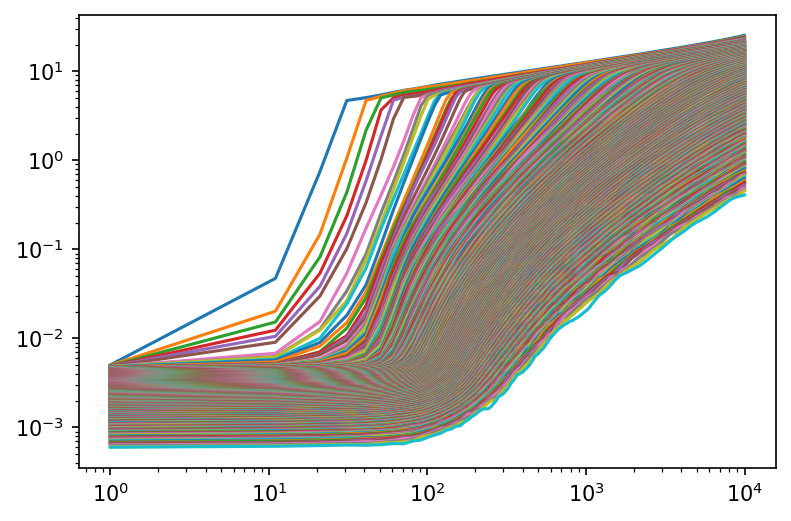

In [4]:
plt.figure(dpi=150)
plt.loglog(np.array(allt),alls.t());

## Plot Observables at a given epoch

### *First looking at samples*

We run 50 MCMC chains for which we plot their stat every 10 steps. We emphasis the samples generated at $t_{MCMC} = k$, here $k=100$.

In [43]:
ep = 9001
myRBM.W = torch.tensor(f['W'+str(ep)])
myRBM.vbias = torch.tensor(f['vbias'+str(ep)])
myRBM.hbias = torch.tensor(f['hbias'+str(ep)])

# Checking images during sampling
vinit = torch.bernoulli(0.5*torch.ones((myRBM.Nv,50), device=myRBM.device, dtype=myRBM.dtype))
vt = vinit

Im = []
Im.append(myRBM.ImConcat(vt[:,:100].t(),ncol=1,nrow=50,sx=28,sy=28,ch=1))
itmax = 20
ΔMC = 10
for i in range(itmax):
    vt,vis_m,_,_ = myRBM.Sampling(vt,it_mcmc=ΔMC)
    if (i*1)*ΔMC == NGibbs:
        Im.append(myRBM.ImConcat(1-vis_m[:,:100].t(),ncol=1,nrow=50,sx=28,sy=28,ch=1))
    else: 
        Im.append(myRBM.ImConcat(vis_m[:,:100].t(),ncol=1,nrow=50,sx=28,sy=28,ch=1))

AllIm=torch.cat(tuple(Im[i] for i in range(itmax)))

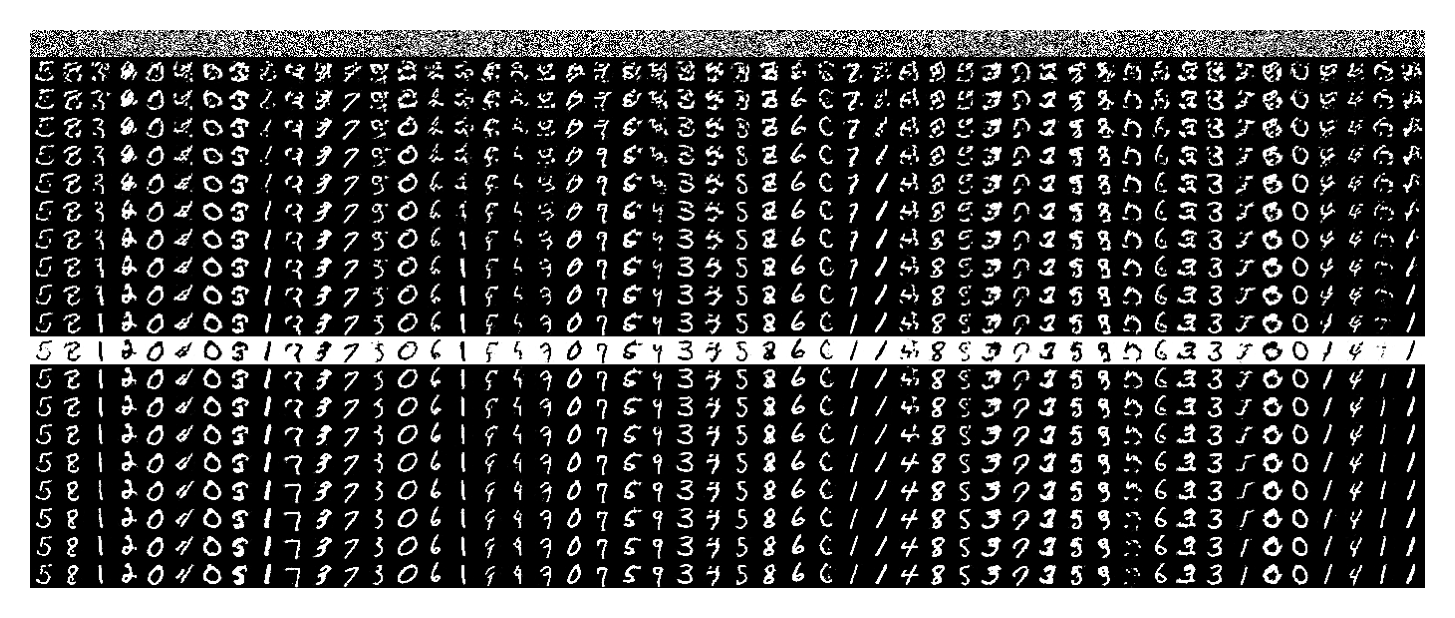

In [44]:
plt.figure(dpi=300)
plt.axis('off')
plt.imshow(AllIm,cmap='gray')

### Computing the AAI

We run a MCMC chain of 1000 chains for which we measure the AAI every 5 steps.

In [45]:
# Loading the dataset
Ns=1000
mnist_trainset = datasets.MNIST('dataset/', train=True, download=True)
X = mnist_trainset.data[:Ns,:,:].reshape(Ns,28*28).float().to(device) / 255.0
X = (X > 0.5) * 1.0
X = X.t()

In [47]:
ep = 9991
myRBM.W = torch.tensor(f['W'+str(ep)])
myRBM.vbias = torch.tensor(f['vbias'+str(ep)])
myRBM.hbias = torch.tensor(f['hbias'+str(ep)])

# Checking images during sampling
vinit = torch.bernoulli(0.5*torch.ones((myRBM.Nv,1000), device=myRBM.device, dtype=myRBM.dtype))
vt = vinit

AATS = []
R = myRBM.ComputeAATS(X,vt,1000)
AATS.append(torch.tensor([R[0],R[1]]).reshape(2,1))
itmax = 200
ΔMC = 5
t_MC = [0]
for i in range(itmax):
    vt,_,_,_ = myRBM.Sampling(vt,it_mcmc=ΔMC)
    R = myRBM.ComputeAATS(X,vt,1000)
    AATS.append(torch.tensor([R[0],R[1]]).reshape(2,1))
    t_MC.append((i+1)*ΔMC)

AllAATS = torch.cat(tuple(AATS),dim=1)

(0.0, 1.0)

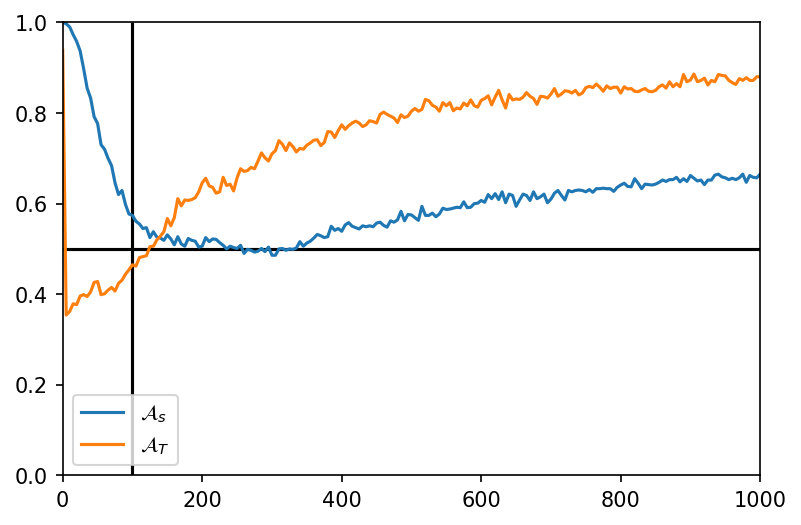

In [48]:
plt.figure(dpi=150)
plt.vlines(NGibbs,0,1,color='black')
plt.hlines(0.5,0,t_MC[-1],color='black')
[a,b] = plt.plot(t_MC,AllAATS.t())
plt.legend([a,b],[r'$\mathcal{A}_s$',r'$\mathcal{A}_T$'])
plt.xlim(0,t_MC[-1])
plt.ylim(0,1)


(0.01, 1)

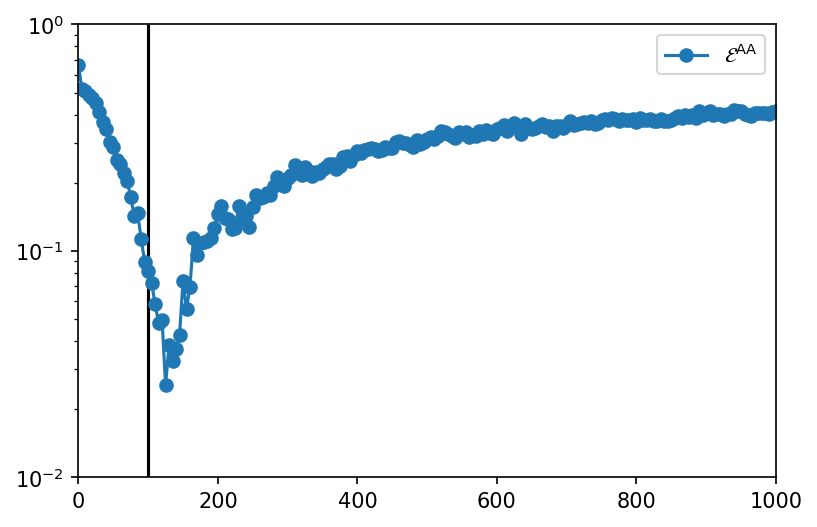

In [52]:
plt.figure(dpi=150)
plt.vlines(NGibbs,0,1,color='black')
a = plt.semilogy(t_MC,np.sqrt((AllAATS[0,:]-0.5)**2 + (AllAATS[1,:]-0.5)**2),'-o',label=r'$\mathcal{E}^{\rm AA}$')
plt.legend()
plt.xlim(0,t_MC[-1])
plt.ylim(1e-2,1)